In [1]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2017-07-25 18:54:51


In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

In [3]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.peak_functions_c as cpf


from   invisible_cities.evm.ic_containers           import S12Params 
from   invisible_cities.evm.ic_containers          import CalibVectors
from   invisible_cities.evm.ic_containers          import DeconvParams
from   invisible_cities.evm.ic_containers          import ThresholdParams
from   invisible_cities.evm.ic_containers          import TriggerParams
from   invisible_cities.core.core_functions  import loc_elem_1d
from   invisible_cities.evm.event_model   import SensorParams
from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
from invisible_cities.icaro.pmaps_mpl import plot_s12


In [4]:
from invisible_cities.evm.pmaps import S1
from invisible_cities.evm.pmaps import S2
from invisible_cities.evm.pmaps import S2Si

In [5]:
import  invisible_cities.icaro.mpl_functions as mpl
import   invisible_cities.reco.sensor_functions as sf       
from     invisible_cities.reco     import wfm_functions as wfm

In [6]:
from invisible_cities.sierpe   import blr

In [7]:
import invisible_cities.evm.event_model as evm
from invisible_cities.types.ic_types import minmax

In [8]:
from invisible_cities.core.exceptions        import SipmEmptyList
from invisible_cities.core.exceptions        import SipmNotFound
from invisible_cities.core.exceptions        import PeakNotFound

In [9]:
from invisible_cities.sierpe             import fee as FE

In [10]:
from invisible_cities.reco.sensor_functions   import convert_channel_id_to_IC_id

In [11]:
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

In [12]:
run_number = 0
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
xpmt = DataPMT.X.values
ypmt = DataPMT.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [13]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)
cid = ['{}'.format(c) for c in channel_id]

In [14]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.001632,0.000003,24.3395,0.7060,7.73100
1,1,18,PMT3,1,-44.9951,-53.6231,0.001632,0.000003,24.8580,0.8744,8.82000
2,2,1,PMT2,1,68.9365,-12.1554,0.001611,0.000003,26.2934,0.7213,8.01375
3,3,19,PMT4,1,0.0000,185.0000,0.001599,0.000003,26.4110,0.7624,8.42224
4,4,27,PMTC,1,-118.9160,141.7180,0.001567,0.000003,26.7098,0.7921,6.23125
5,5,26,PMTB,1,-182.1890,32.1249,0.001650,0.000004,22.4456,0.8660,5.65180
6,6,9,PMTA,1,-160.2150,-92.5000,0.001593,0.000003,23.3552,0.7062,7.37840
7,7,8,PMT9,1,-63.2737,-173.8430,0.001612,0.000003,33.8821,0.7278,11.94840
8,8,23,PMT8,1,63.2737,-173.8430,0.001601,0.000003,21.8220,0.7303,6.11073
9,9,22,PMT7,1,160.2150,-92.5000,0.001593,0.000003,25.8020,0.7160,7.46200


In [15]:
def draw_pmt_map(cid, xpmt,ypmt):
    fig, ax = plt.subplots()
    plt.plot(xpmt, ypmt, 'o')

    for c, x,y in zip(cid, xpmt,ypmt):
        xy = (x,y)
        offsetbox = TextArea(c, minimumdescent=False)
        ab = AnnotationBbox(offsetbox, xy)
        ax.add_artist(ab)

    plt.show()

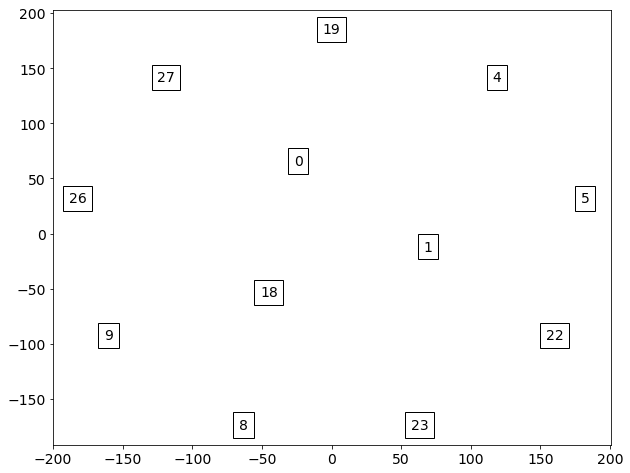

In [16]:
draw_pmt_map(cid, xpmt,ypmt)

### Beware of inconsistencies when simulating trigger.  Monte Carlo Map must be same than Data Map.

In [17]:
event=0

In [23]:
#filename = '/Users/jjgomezcadenas/Projects/ICDATA/electrons_40keV_z250_MCRD.h5'
filename = '/Users/jjgomezcadenas/Projects/ICDATA/MC_PreProd_July_2017/dst_NEXT_v1_00_05_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5'

h5in = tb.open_file(filename, "r") 
NEVT_pmt, pmtrd, sipmrd = tbl.get_rd_vectors(h5in)
_, NPMT,   PMTWL = pmtrd .shape
_, NSIPM, SIPMWL = sipmrd.shape
PMTWL_FEE = int(PMTWL // FE.t_sample)
sp = SensorParams(NPMT, PMTWL_FEE, NSIPM, SIPMWL)

In [24]:
print(sp)

####################
SensorParams
####################
npmt: 12
pmtwl: 48000
nsipm: 1792
sipmwl: 1200



In [25]:
print(PMTWL_FEE )

48000


In [26]:
dataPMT, blrPMT = sf.simulate_pmt_response(event, pmtrd, adc_to_pes)

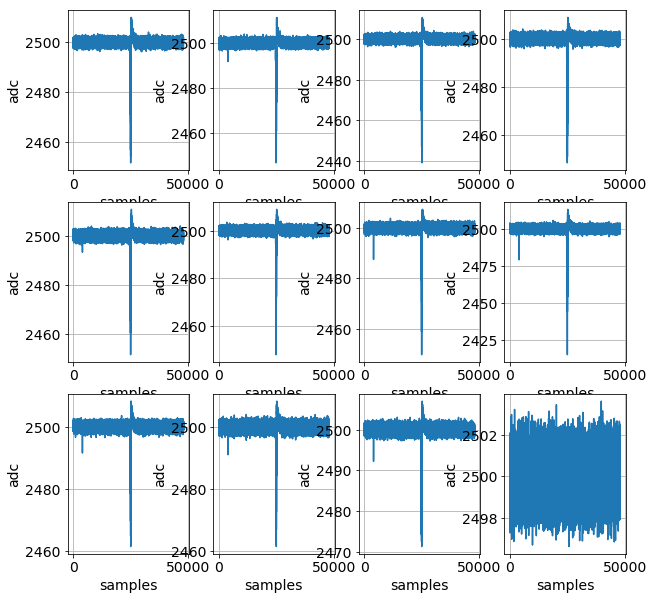

In [27]:
mpl.plot_pmt_waveforms(dataPMT, zoom=False, window_size=1200, figsize=(10,10))

In [ ]:
mpl.plot_pmt_waveforms(dataPMT, zoom=True, window_size=1200, figsize=(10,10))

In [ ]:
mpl.plot_pmt_waveforms(blrPMT, zoom=True, window_size=1200, figsize=(10,10))

In [ ]:
RWF = dataPMT.astype(np.int16)

In [ ]:
RWF.dtype

In [ ]:
BLR = blrPMT

In [ ]:
CWF = blr.deconv_pmt(RWF,
                     coeff_c,
                     coeff_blr,
                     pmt_active,
                     n_baseline=28000,
                     thr_trigger=5)

        

In [ ]:
mpl.plot_wfa_wfb(CWF, BLR, zoom=True, window_size=800)

In [ ]:
diff = wfm.compare_cwf_blr(cwf = [CWF],
                           pmtblr = [BLR],
                           event_list = [0],
                           window_size = 500)

In [ ]:
diff

In [ ]:
np.sum(diff)

### Emulate trigger

In [ ]:
thresholds = ThresholdParams(thr_s1=0.5 * units.pes,
                      thr_s2=1.0 * units.pes,
                      thr_MAU=3*units.adc,
                      thr_sipm=1.5*units.pes,
                      thr_SIPM=15*units.pes)

s2par = S12Params(time = minmax(min    = 101 * units.mus,
                           max    = 799 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin  = True)



In [ ]:
csum, csum_mau = cpf.calibrated_pmt_sum(CWF,
                                            adc_to_pes,
                                            pmt_active  = pmt_active,
                                            n_MAU       = 100,
                                            thr_MAU     = thresholds.thr_MAU)

In [ ]:
mpl.plot_signal_vs_time_mus(csum,
                        t_min      = 0,
                        t_max      = 800,
                        signal_min =    -10,
                        signal_max =  120,
                        figsize=(6,6))

In [ ]:
s2_ene, s2_indx = cpf.wfzs(csum, threshold=thresholds.thr_s2)

In [ ]:
s2 = cpf.find_s2(csum, s2_indx, **s2par._asdict())

In [ ]:
s2

In [ ]:
plot_s12(s2)

In [ ]:
wfm_ene, wfm_index = cpf.wfzs(CWF[2].astype(np.double),
                                          threshold = min_height)

In [ ]:
s2 = cpf.find_s2(CWF[2].astype(np.double),wfm_index, **s2par._asdict())

In [ ]:
plot_s12(s2)

In [ ]:
s2

In [ ]:
# Min/max height of signal in ADC counts per PMT
tr_channels = [0,1]
min_number_channels = 2


min_height =   15 * units.adc
max_height = 20000 * units.adc

# Min/max width in ns
min_width =  3000 * units.ns
max_width = 15000 * units.ns

# Min/max charge in ADC counts per PMT
min_charge =  3000 * units.adc
max_charge = 50000 * units.adc
height = minmax(min = min_height, max = max_height)
charge = minmax(min = min_charge, max = max_charge)
width  = minmax(min = min_width , max = max_width )
data_mc_ratio = 0.8

In [ ]:
IC_ids_selection = convert_channel_id_to_IC_id(DataPMT, tr_channels)

In [ ]:
IC_ids_selection

In [ ]:
peak_data = {}  
for pmt_id in IC_ids_selection:        
    wfm_ene, wfm_index = cpf.wfzs(CWF[pmt_id].astype(np.double),
                                          threshold = min_height)
           
    s2 =  cpf.find_s2(CWF[pmt_id].astype(np.double), wfm_index, **s2par._asdict()) 
    peak_data[pmt_id] = s2

In [ ]:
peak_data

In [ ]:
tp = TriggerParams(trigger_channels    = tr_channels,
                   min_number_channels = min_number_channels,
                             charge              = charge * data_mc_ratio,
                             height              = height * data_mc_ratio,
                             width               = width)

In [ ]:

def TriggerFilter(trigger_params):
    """Trigger Filter module"""
    def trigger_filter(peak_data : '{channel_no: s2}'):
        min_charge, max_charge = trigger_params.charge
        min_height, max_height = trigger_params.height
        min_width , max_width  = trigger_params. width
        n_channels_fired = 0
        print(min_width,  max_width)
        print(min_charge,  max_charge)
        print(min_height,  max_height)
        for channel_no, s2 in peak_data.items():
            for peak_number, peak in s2.peaks.items():
                print(peak.width)
                print(peak.total_energy)
                print(peak.height)
                if         min_width  < peak.width        <= max_width:
                    if     min_charge < peak.total_energy <= max_charge:
                        if min_height < peak.height <= max_height:
                            n_channels_fired += 1
                            print(n_channels_fired)
                            if n_channels_fired == trigger_params.min_number_channels:
                                return True
        return False
    return trigger_filter

In [ ]:
tf = TriggerFilter(tp)

In [ ]:
peak_data

In [ ]:
tf(peak_data)